# Assignment 2


## Task 1
**Sol:**

- 1.  $Q(\mathbf{s}) = \mathbf{s^T\Sigma \Sigma^T s}\\=\sum_{i=1}^p \sigma_{i,i}^2s_i^2 \\ = \sigma_{1,1}^2\sum_{i=1}^p \frac{\sigma_{i,i}^2}{\sigma_1^2}s_i^2 \\ \leq  \sigma_{1,1}^2 \sum_{i=1}^p s_i^2=\sigma_{1,1}^2$  
equality holds when $s_1^2=1, s_i^2=0, (i\geq2)$.
So, a possilble $\mathbf{\hat s}$ could be $\mathbf{\hat s}=[1, 0, ..., 0]^T$.



- 2. SVD of $\mathbf X$ is $\mathbf{X=U\Sigma V^T}$, where $\mathbf U$ is an orthogonal matrix and all columns of $\mathbf U$ form a set of orthonormal bases of $\mathbb R^p$. So, vector $\mathbf a$ can be written as: $\mathbf{a=Uk}$.   
Note that orthogonal matrices do not change the length of a vector, because $\mathbf{\Vert a\Vert^2 = \Vert Uk \Vert^2 = k^TU^TUk = k^Tk = \Vert k \Vert^2}$, where $\mathbf{U}$ is an orthogonal matrix and $\mathbf{UU^T=I}$. That is,
$\mathbf{\Vert k\Vert = \Vert a \Vert = 1}$.  
Then,   
$\dfrac{1}{N}\mathbf{a^TXX^Ta}\\ =\dfrac{1}{N}\mathbf{k^TU^T(U\Sigma V^T )(V\Sigma^TU^T)Uk}\\=\dfrac{1}{N}\mathbf{k^T(U^TU)\Sigma (V^T V)\Sigma^T(U^TU)k}\\=\dfrac{1}{N}\mathbf{k^T\Sigma \Sigma^Tk}$.  
According the conclusion of the last problem,  
$\mathbf{\hat k}=\mathop{argmax}_{\mathbf k,\ s.t., \Vert \mathbf k \Vert = 1 } \mathbf{k^T\Sigma \Sigma^Tk}= \left[1\ 0\ \cdots\ 0 \right]^T$.  
Hence,   
$\mathbf{ \hat a = U\hat k =u_1}$ maximizes$\dfrac{1}{N}\mathbf{a^TXX^Ta}$.  



## Task 2


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from numpy.linalg import svd, norm


fpath = "./data/task2_data/yaleBfaces"
train_subdir = fpath + '/subset0/'
test_subdirs = [fpath + '/subset%d/'%(i+1) for i in range(4)]

# reading images and labels from file
# trainging images
TrainT = np.array( [np.ravel(plt.imread(train_subdir + imgpth)) \
          for imgpth in listdir(train_subdir) ] ).T
# training labels
LabelT = np.array([imgpth.split('_')[0][-2:] for\
                   imgpth in listdir(train_subdir)]).astype('int32')

# list of test images in subsets[1-4]
TestS = [ np.array( [np.ravel(plt.imread(test_subdirs[i] + imgpth)) \
          for imgpth in listdir(test_subdirs[i]) ] ).T for  i in range(4)]

# list of test labels in subsets[1-4]
LabelS =[ np.array([imgpth.split('_')[0][-2:] for\
                   imgpth in listdir(test_subdirs[i])]).astype('int32') for i in range(4) ]

- 1. function `first20SingularVectors` takes vectorized images [T] as input, returns first 20 singular vectors.

In [2]:
def first20SingularVectors(T):
    '''
    find out first 20 principal components of T
    '''
    n_samples = T.shape[1]
    
    center = np.mean(T, axis=1)    # centralize T
    Mu = np.tile(center, (n_samples, 1)).T
    
    u, s, vh = svd(T-Mu) # svd
    
    return np.mat(u[:, 0:20])

 Now display the first 3 principal components.

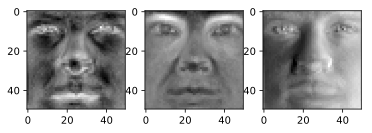

In [3]:
u = first20SingularVectors(TrainT)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# display the first 3 principal components
plt.subplot(1,3,1)
plt.imshow(u[:,0].reshape((50,50)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(u[:,1].reshape((50,50)), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(u[:,2].reshape((50,50)), cmap='gray')

- 2. function `evaluateClassification` takes vectorized traing images [`T`], training labels[`LabelT`], test image[`S`], test labels [`LabelS`], and number of PCs [`k`] as input, returns first 20 singular vectors.

In [5]:
def evaluateClassification(T, LabelT, S, LabelS,k, start=0):
    '''
    evaluating the classification result using training set (T, LabelT) and test set (S, LabelS), principal components 
    [start:k] are applied in reducing dimensionality, where default [start] is 0.
    '''
    
    Uk = first20SingularVectors(TrainT)[:, start:k];   # first 20 principal components    
    center = np.mean(T, axis=1)  # mean value of all samples in training set
    
    # centralization
    def centralize(X, center):        
        n_samples = X.shape[1]
        Mu = np.tile(center, (n_samples, 1)).T 
        Xc = X - Mu        
        return np.mat(Xc)
    
    # dimensionality reduction
    Yt = Uk.T * centralize(T, center)
    Ys = Uk.T * centralize(S, center)    
    
    
    # classification and evaluation
    n_train = Yt.shape[1]
    n_tests = Ys.shape[1]
    
    error_rate = 0
    for s in range(n_tests):
        dist = norm(np.tile(Ys[:, s], (1, n_train)) - Yt, axis=0) # euclidean distance
        
        index_nns = np.argsort(dist)[0:3]  
        pred_nns = np.array([LabelT[i] for i in index_nns]) # prediction of 3 nearest neighbours       
        
        prediction = np.bincount(pred_nns).argmax() # the most frequent occurrence as final prediction 
        reallabel = LabelS[s]
        
        error_rate += (prediction != reallabel) # mismatch
    return (error_rate/n_tests)


Evaluating through subset 1-4

In [6]:
error_rates = []
for i in range(4):
    print("Evaluating subset %d..."%(i+1))
    error_rate = np.array([evaluateClassification(TrainT, LabelT, TestS[i], LabelS[i], k) \
              for k in range(20)] )
    print("*** Subset %d error rate: %.2f %%"%(i+1, 100*error_rate[-1]))
    error_rates.append(error_rate)
print('Done!')

Evaluating subset 1...
*** Subset 1 error rate: 5.83 %
Evaluating subset 2...
*** Subset 2 error rate: 58.33 %
Evaluating subset 3...
*** Subset 3 error rate: 82.14 %
Evaluating subset 4...
*** Subset 4 error rate: 87.89 %
Done!


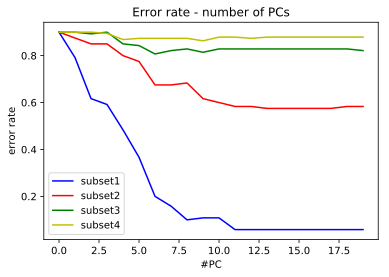

In [9]:
plt.plot(np.arange(20), error_rates[0], 'b-',
         np.arange(20), error_rates[1], 'r-',
         np.arange(20), error_rates[2], 'g-',
         np.arange(20), error_rates[3], 'y-',)
plt.title('Error rate - number of PCs')
plt.xlabel('#PC')
plt.ylabel('error rate')
plt.legend(("subset1",
        "subset2",
        "subset3",
        "subset4")
       )
'''
'''
plt.show()

- 3. Eliminating the first 3 PCs, repeat the evaluation. 

In [10]:
error_rates_2 = []
for i in range(4):
    print("Evaluating subset %d..."%(i+1))
    error_rate = np.array([evaluateClassification(TrainT, LabelT, TestS[i], LabelS[i], k, start=3) \
              for k in range(3, 20)] )
    print("*** Subset %d error rate: %.2f %%"%(i+1, 100*error_rate[-1]))
    error_rates_2.append(error_rate)
print('Done!')



Evaluating subset 1...
*** Subset 1 error rate: 5.83 %
Evaluating subset 2...
*** Subset 2 error rate: 30.83 %
Evaluating subset 3...
*** Subset 3 error rate: 70.00 %
Evaluating subset 4...
*** Subset 4 error rate: 90.53 %
Done!


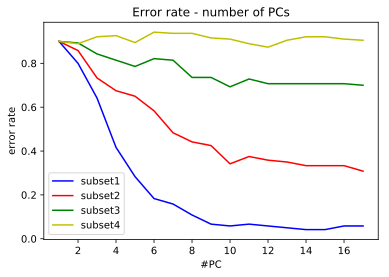

In [13]:
plt.plot(np.arange(1,18), error_rates_2[0], 'b-',
         np.arange(1,18), error_rates_2[1], 'r-',
         np.arange(1,18), error_rates_2[2], 'g-',
         np.arange(1,18), error_rates_2[3], 'y-',)
plt.title('Error rate - number of PCs')
plt.xlabel('#PC')
plt.ylabel('error rate')
plt.legend(("subset1",
        "subset2",
        "subset3",
        "subset4")
       )
plt.show()

The prediction error in subset 2 and subset 3 decreased if we take the first 3 PCs. This is probably because in subset 2 and subset 3, data drawn out of different classes is more seperatable when projected to the 3rd to 20th PCs than projected to 1st to 17th PCs.   
PCA is an **unsupervised process** and is helpful in dimensional reduction, but when projected to principal components, classification of data from different classes could be easier or harder depending on  the distribution of each class.   
The following experiment shows the case that classification would be better if data projected to the second pricipal component than to the first.

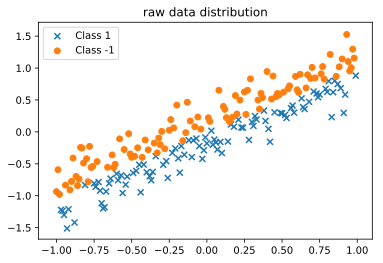

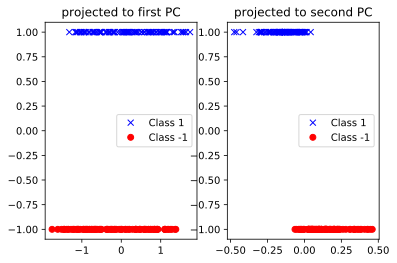

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

X = np.arange(-1, 1, 0.01)
Y = X + 0.3*np.random.randn(X.shape[0])
TrainT = np.concatenate(([X], [Y]))
# class 1
class1_points = np.array([(X[i], Y[i]) for i in range(X.shape[0]) if X[i] > Y[i]])

# class 2
class2_points = np.array([(X[i], Y[i]) for i in range(X.shape[0]) if X[i] < Y[i]])


# visual 2 classes of raw data
plt.scatter(class1_points[:,0], class1_points[:,1], marker='x')
plt.scatter(class2_points[:,0], class2_points[:,1], marker='o')
plt.title('raw data distribution')
plt.legend(('Class 1','Class -1'))

# pca
[u, s, vh] = svd(TrainT)
u = np.mat(u)
class1_points = np.mat(class1_points).T
class2_points = np.mat(class2_points).T

projection1_class1 = u[:, 0].T * class1_points;
projection1_class2 = u[:, 0].T * class2_points;
class1_reduced1 = np.array([(projection1_class1[0,i], 1) for i in range(projection1_class1.shape[1])])
class2_reduced1 = np.array([(projection1_class2[0,i], -1) for i in range(projection1_class2.shape[1])])

# visualize reduced 2 classes
plt.figure()
plt.subplot(121)
plt.plot(class1_reduced1[:,0],class1_reduced1[:,1], 'bx',
         class2_reduced1[:,0],class2_reduced1[:,1], 'ro',)
plt.title('projected to first PC')
plt.legend(('Class 1','Class -1'))

projection2_class1 = u[:, 1].T * class1_points;
projection2_class2 = u[:, 1].T * class2_points;
class1_reduced2 = np.array([(projection2_class1[0,i], 1) for i in range(projection2_class1.shape[1])])
class2_reduced2 = np.array([(projection2_class2[0,i], -1) for i in range(projection2_class2.shape[1])])

plt.subplot(122)
plt.plot(class1_reduced2[:,0],class1_reduced2[:,1], 'bx',
         class2_reduced2[:,0],class2_reduced2[:,1], 'ro',)
plt.title('projected to second PC')
plt.legend(('Class 1','Class -1'))
plt.show()